## Train

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

import os
import cv2
import json

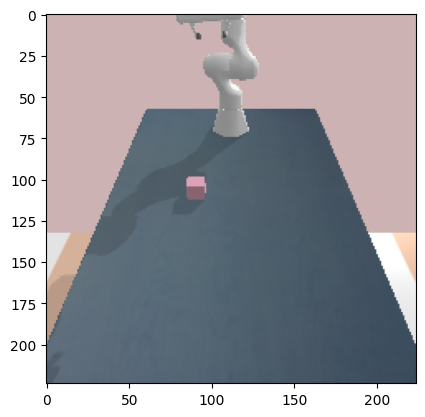

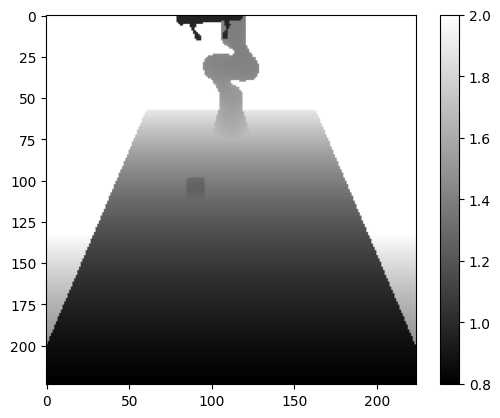

Label: {'cube_position': [0.5035419673910272, -0.1415720652629452, 0.6581052072807108], 'initial': {'ee_position': [0.41438564369013325, -0.057438045175789244, 1.245880822217281], 'ee_orientation': [0.9914939869517543, -0.02919205716354635, 0.1166122572497007, -0.049890671434691385], 'joint_states': [-0.1384062765764809, -0.48961880227261556, -0.045856661116072894, -1.8754504126353573, 0.11171206068130779, 1.6031326034619204, 0.6715928791911877]}, 'final': {'ee_position': [0.504081603887585, -0.1416320078801475, 0.9589167799259359], 'ee_orientation': [0.9908070177008821, -0.03060926597383484, 0.12532069560015927, -0.04073388964387293], 'joint_states': [-0.14872376629211476, -0.17850577634936599, -0.1552467585919568, -2.330377719797355, 0.16922638483435326, 2.367915894751892, 0.4340733679445207]}, 'success': 1}
(224, 224, 3) (224, 224)


In [2]:
path = "../dataset/"

# Load data
for i in range(10):
    depth_img = np.load(f"{path}depth/depth_{i}.npy")
    rgb_img = cv2.imread(f"{path}rgb/rgb_{i}.png")
    label = json.load(open(f"{path}labels/label_{i}.json"))

    plt.imshow(rgb_img)
    plt.show()

    plt.imshow(depth_img, cmap='gray')
    plt.colorbar()
    plt.show()

    print("Label:", label)

    print(rgb_img.shape, depth_img.shape)

    break

In [3]:
import torch
import torch.nn as nn
from torchvision.models import vit_b_16

class RGBDViTGraspModel(nn.Module):
    def __init__(self, out_dim=7):
        """
        out_dim example:
        3  : EE position (x, y, z)
        4  : EE orientation (quaternion)
        """
        super().__init__()

        # ------------------
        # RGB encoder (ViT)
        # ------------------
        self.rgb_vit = vit_b_16(weights="IMAGENET1K_V1")
        self.rgb_vit.heads = nn.Identity()
        rgb_feat_dim = 768

        # ------------------
        # Depth encoder (CNN)
        # ------------------
        self.depth_encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        depth_feat_dim = 64

        # ------------------
        # Fusion + policy head
        # ------------------
        self.policy_head = nn.Sequential(
            nn.Linear(rgb_feat_dim + depth_feat_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, out_dim)
        )

    def forward(self, rgb, depth):
        """
        rgb   : (B, 3, 224, 224)
        depth : (B, 1, 224, 224)
        """

        rgb_feat = self.rgb_vit(rgb)                  # (B, 768)
        depth_feat = self.depth_encoder(depth)        # (B, 64, 1, 1)
        depth_feat = depth_feat.view(depth_feat.size(0), -1)

        fused = torch.cat([rgb_feat, depth_feat], dim=1)
        action = self.policy_head(fused)

        return action

In [4]:
import os
import json
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class RGBDGraspDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir

        self.rgb_dir = os.path.join(root_dir, "rgb")
        self.depth_dir = os.path.join(root_dir, "depth")
        self.label_dir = os.path.join(root_dir, "labels")

        self.indices = sorted([
            int(f.split("_")[1].split(".")[0])
            for f in os.listdir(self.rgb_dir)
            if f.endswith(".png")
        ])

        self.rgb_transform = transforms.Compose([
            transforms.ToTensor(),                 # (3,H,W), [0,1]
            transforms.Resize((224, 224))
        ])

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        i = self.indices[idx]

        # -------- RGB --------
        rgb_path = os.path.join(self.rgb_dir, f"rgb_{i}.png")
        rgb = cv2.imread(rgb_path)
        rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
        rgb = self.rgb_transform(rgb)

        # -------- Depth --------
        depth_path = os.path.join(self.depth_dir, f"depth_{i}.npy")
        depth = np.load(depth_path).astype(np.float32)

        # normalize depth
        # depth = (depth - depth.min()) / (depth.max() - depth.min() + 1e-6)
        depth = torch.from_numpy(depth).unsqueeze(0)   # (1,H,W)
        depth = torch.nn.functional.interpolate(
            depth.unsqueeze(0),
            size=(224, 224),
            mode="bilinear",
            align_corners=False
        ).squeeze(0)

        # -------- Label --------
        label_path = os.path.join(self.label_dir, f"label_{i}.json")
        with open(label_path, "r") as f:
            label = json.load(f)

        pos = torch.tensor(label["final"]["ee_position"], dtype=torch.float32)
        quat = torch.tensor(label["final"]["ee_orientation"], dtype=torch.float32)

        target = torch.cat([pos, quat], dim=0)  # (7,)

        return rgb, depth, target

dataset = RGBDGraspDataset("../dataset")

dataloader = DataLoader(
    dataset,
    batch_size=8,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

# -----------------------------
# Setup
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = RGBDViTGraspModel(out_dim=7).to(device)

optimizer = optim.AdamW(
    model.parameters(),
    lr=3e-4,
    weight_decay=1e-4
)

criterion = nn.MSELoss()

# -----------------------------
# Training
# -----------------------------
num_epochs = 20

# for epoch in range(num_epochs):
# use tqdm for progress bar
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    # for rgb, depth, target in dataloader:
    # use tqdm for progress bar
    for rgb, depth, target in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        rgb = rgb.to(device)
        depth = depth.to(device)
        target = target.to(device)

        # Forward
        pred = model(rgb, depth)

        # Loss
        loss = criterion(pred, target)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {avg_loss:.6f}")

# -----------------------------
# save model
torch.save(model.state_dict(), "rgbd_vit_grasp_model.pth")


Epoch 1/20: 100%|██████████| 625/625 [04:15<00:00,  2.45it/s]


Epoch [1/20] | Loss: 0.010377


Epoch 2/20: 100%|██████████| 625/625 [04:58<00:00,  2.09it/s]


Epoch [2/20] | Loss: 0.008524


Epoch 3/20: 100%|██████████| 625/625 [05:02<00:00,  2.06it/s]


Epoch [3/20] | Loss: 0.008390


Epoch 4/20: 100%|██████████| 625/625 [04:45<00:00,  2.19it/s]


Epoch [4/20] | Loss: 0.008308


Epoch 5/20: 100%|██████████| 625/625 [04:42<00:00,  2.21it/s]


Epoch [5/20] | Loss: 0.008288


Epoch 6/20: 100%|██████████| 625/625 [04:39<00:00,  2.24it/s]


Epoch [6/20] | Loss: 0.008258


Epoch 7/20: 100%|██████████| 625/625 [04:38<00:00,  2.25it/s]


Epoch [7/20] | Loss: 0.008261


Epoch 8/20: 100%|██████████| 625/625 [04:37<00:00,  2.25it/s]


Epoch [8/20] | Loss: 0.008247


Epoch 9/20: 100%|██████████| 625/625 [04:40<00:00,  2.23it/s]


Epoch [9/20] | Loss: 0.008220


Epoch 10/20: 100%|██████████| 625/625 [04:39<00:00,  2.23it/s]


Epoch [10/20] | Loss: 0.008221


Epoch 11/20: 100%|██████████| 625/625 [04:35<00:00,  2.27it/s]


Epoch [11/20] | Loss: 0.008183


Epoch 12/20: 100%|██████████| 625/625 [04:40<00:00,  2.23it/s]


Epoch [12/20] | Loss: 0.008191


Epoch 13/20: 100%|██████████| 625/625 [04:39<00:00,  2.24it/s]


Epoch [13/20] | Loss: 0.008176


Epoch 14/20: 100%|██████████| 625/625 [04:42<00:00,  2.21it/s]


Epoch [14/20] | Loss: 0.008177


Epoch 15/20: 100%|██████████| 625/625 [04:41<00:00,  2.22it/s]


Epoch [15/20] | Loss: 0.008145


Epoch 16/20: 100%|██████████| 625/625 [04:40<00:00,  2.23it/s]


Epoch [16/20] | Loss: 0.008154


Epoch 17/20: 100%|██████████| 625/625 [04:41<00:00,  2.22it/s]


Epoch [17/20] | Loss: 0.008149


Epoch 18/20: 100%|██████████| 625/625 [04:41<00:00,  2.22it/s]


Epoch [18/20] | Loss: 0.008162


Epoch 19/20: 100%|██████████| 625/625 [04:36<00:00,  2.26it/s]


Epoch [19/20] | Loss: 0.008158


Epoch 20/20: 100%|██████████| 625/625 [04:35<00:00,  2.27it/s]


Epoch [20/20] | Loss: 0.008140


In [6]:
import torch
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load trained model
model = RGBDViTGraspModel(out_dim=7).to(device)
model.load_state_dict(torch.load("rgbd_vit_grasp_model.pth", map_location=device))
model.eval()

# -----------------------------
# Run inference on test samples
# -----------------------------
with torch.no_grad():
    for rgb, depth, target in dataloader:
        rgb = rgb.to(device)
        depth = depth.to(device)
        target = target.to(device)

        pred = model(rgb, depth)   # (B, 7)

        print("Predicted EE Pose:", pred.cpu().numpy())
        print("Target EE Pose   :", target.cpu().numpy())
        break  # just one batch for testing


Predicted EE Pose: [[ 5.0349379e-01  5.7236357e-03  9.5539218e-01  9.8165101e-01
   9.9837780e-06  1.5201500e-02  1.5294872e-02]
 [ 5.0337094e-01  5.7226568e-03  9.5515364e-01  9.8140401e-01
  -1.2256205e-06  1.5194582e-02  1.5303990e-02]
 [ 5.0333434e-01  5.7223812e-03  9.5508301e-01  9.8133039e-01
  -4.5709312e-06  1.5192544e-02  1.5306674e-02]
 [ 5.0347006e-01  5.7231029e-03  9.5534092e-01  9.8160774e-01
   8.2552433e-06  1.5200062e-02  1.5296146e-02]
 [ 5.0401038e-01  5.7274019e-03  9.5638895e-01  9.8269361e-01
   5.7566911e-05  1.5230475e-02  1.5256101e-02]
 [ 5.0375181e-01  5.7252347e-03  9.5588624e-01  9.8217487e-01
   3.4105033e-05  1.5215842e-02  1.5275147e-02]
 [ 5.0404900e-01  5.7275379e-03  9.5646107e-01  9.8277384e-01
   6.1359257e-05  1.5232602e-02  1.5253060e-02]
 [ 5.0398576e-01  5.7269093e-03  9.5633698e-01  9.8264796e-01
   5.5700541e-05  1.5228970e-02  1.5257454e-02]]
Target EE Pose   : [[ 0.389287    0.06626324  0.9589298   0.9944242  -0.05312879  0.03520593
  -0.08